In [1]:
import omicverse as ov
ov.utils.ov_plot_set()
from matplotlib import rcParams

# 设置全局字体为Arial
rcParams['font.family'] = 'Arial'

2023-08-27 12:15:24.014082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 12:15:24.489685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-27 12:15:24.489754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-27 12:15:24.489760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
import anndata
import omicverse as ov
adata2=ov.utils.read('data/tsp1_bladder_mesenchymeToMyofibroblast_forPaper.h5ad')
adata2


In [ ]:
adata2_raw=anndata.read_h5ad('data/tsp1_bladder_raw.h5ad')
adata2_raw.X=adata2_raw.layers['raw_counts'].copy()

In [ ]:
adata2_raw=ov.pp.qc(adata2_raw,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
adata2_raw

In [ ]:
adata2_raw=ov.pp.preprocess(adata2_raw,mode='shiftlog|pearson',n_HVGs=3000,)
adata2_raw

In [ ]:
import pandas as pd
ret_pd=pd.DataFrame(index=ret)
ret_pd['adata2_raw']=adata2_raw.obs.loc[ret,'cell_ontology_class'].values
ret_pd['adata2']=adata2.obs.loc[[i+'-0' for i in ret],'manual_annotation'].values
ret_pd.head()

In [ ]:
adata21=adata2_raw[ret].copy()
adata21.obs['manual_annotation']=ret_pd['adata2'].values

In [ ]:
adata21.obs['latent_time']=adata2[[i+'-0' for i in ret]].obs['latent_time'].values
adata21

In [ ]:
adata21.write_h5ad('data/tsp1_bladder_scvelo.h5ad',compression='gzip')

## model

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class RadioModel(nn.Module):
    def __init__(self, input_dim):
        super(RadioModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 1)
    
    def forward(self, x):

        x=self.fc1(x)
        x=F.relu(x)
        x=self.fc2(x)
        x=F.relu(x)
        x=self.fc3(x)
        x=F.relu(x)
        x = self.fc4(x)
        return x

class ANNmodel(object):

    def __init__(self,adata,basis,pseudotime,input_dim,batch_size,cpu):
        device = torch.device(cpu)
        self.model = RadioModel(input_dim).to(device)
        self.adata=adata

        # Assuming you have your X_train, Y_train, X_test, and Y_test tensors
        ran=np.random.choice(adata.obs.index.tolist(),8*(len(adata.obs.index.tolist())//10))
        ran_r=list(set(adata.obs.index.tolist())-set(ran))
        
        X_train=adata[ran].obsm[basis]
        Y_train=adata.obs.loc[ran,pseudotime]
        X_test=adata[ran_r].obsm[basis]
        Y_test=adata.obs.loc[ran_r,pseudotime]
        # Convert X_train and y_train into PyTorch tensors
        self.X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        self.Y_train = torch.tensor(Y_train.values.reshape(len(Y_train.values),1), dtype=torch.float32).to(device)
        
        # Convert x_test and y_test into PyTorch tensors and move to GPU
        self.X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        self.Y_test = torch.tensor(Y_test.values.reshape(len(Y_test.values),1), dtype=torch.float32).to(device)
        
        # Create a DataLoader for batching
        batch_size = batch_size
        self.train_dataset = TensorDataset(self.X_train, self.Y_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)


    def train(self,n_epochs):
        train_losses = []
        val_losses = []
        train_maes = []
        val_maes = []
        # Training loop
        criterion = nn.MSELoss()  # Mean squared error loss
        optimizer = optim.Adam(self.model.parameters())

        num_epochs = n_epochs  # Adjust as needed
        for epoch in range(num_epochs):
            for batch_X, batch_y in self.train_loader:
                optimizer.zero_grad()  # Clear gradients
        
                # Forward pass
                outputs = self.model(batch_X)
        
                # Compute loss
                loss = criterion(outputs, batch_y)
        
                # Backpropagation
                loss.backward()
        
                # Update weights
                optimizer.step()

            train_losses.append(loss.item())
            train_mae = torch.mean(torch.abs(outputs - batch_y))
            train_maes.append(train_mae.item())
            
            self.model.eval()
            with torch.no_grad():
                outputs = self.model(self.X_test)
                val_loss = criterion(outputs, self.Y_test)
                val_losses.append(val_loss.item())
                val_mae = torch.mean(torch.abs(outputs - self.Y_test))
                val_maes.append(val_mae.item())

        self.train_losses=train_losses
        self.val_losses=val_losses
        self.train_maes=train_maes
        self.val_maes=val_maes

    def predicted(self,x):
        return self.model(x)


    def save(self,save_path):
        # Save the entire model (architecture and parameters)
        torch.save(self.model.state_dict(), save_path)

    def load(self,load_path):
        self.model.load_state_dict(torch.load(load_path))
        

    

## HVGs-train

In [3]:
adata=ov.utils.read('data/tsp1_bladder_scvelo.h5ad',compression='gzip')

In [4]:
adata

AnnData object with n_obs × n_vars = 3478 × 22110
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'mean', 'dispersions', 'dispersions_norm', 'mean', 'std', 'mt', 'n_cells', 'percent_cells', 'robust', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'scrublet', 'sex_colors',

In [5]:
adata1=adata.copy()
import scanpy as sc
sc.pp.highly_variable_genes(adata1, n_top_genes=3000, flavor="seurat_v3")
adata1=adata1[:,adata1.var['highly_variable']==True]
adata1

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


View of AnnData object with n_obs × n_vars = 3478 × 3000
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'mean', 'dispersions', 'dispersions_norm', 'mean', 'std', 'mt', 'n_cells', 'percent_cells', 'robust', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features', 'highly_variable', 'means', 'variances', 'variances_norm'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colo

In [6]:
import Epiverse as ev
ev.utils.lsi(adata1, n_components=100, n_iter=15)

In [186]:
ltnn_model=ANNmodel(adata1,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=100,batch_size=100,
                    cpu='cuda:0')
ltnn_model.train(n_epochs=100)

In [187]:
ltnn_model.save('model/model_100.h5')

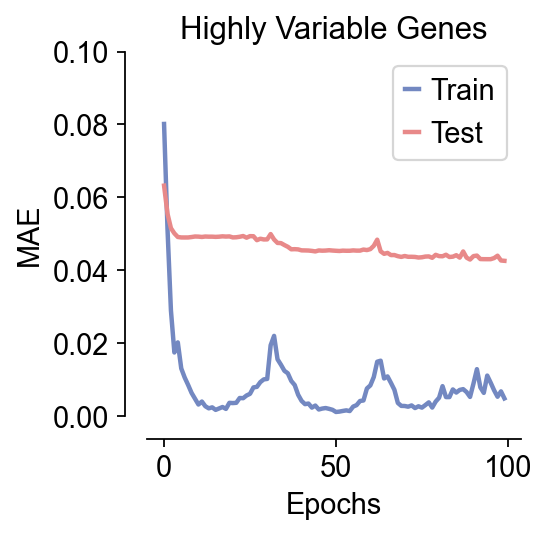

In [88]:
#定义图片大小
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))

epochs=100

ax.plot(range(epochs),ltnn_model.train_maes,
         label='Train',color='#7388c1',lw=2)
ax.plot(range(epochs),ltnn_model.val_maes,
         label='Test',color='#e88989',lw=2)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlabel('Epochs',fontsize=fontsize)
ax.set_ylabel('MAE',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(0,0.1)

#设置横纵坐标轴字体
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(False)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.set_title(f'Highly Variable Genes',
            fontsize=fontsize+1)

plt.savefig("figures/fig2/mae_hvgs.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/mae_hvgs.pdf",dpi=300,bbox_inches = 'tight')

In [101]:
import seaborn as sns
X_val=adata1.obsm['X_lsi']
Y_val=adata1.obs['latent_time'].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert x_test and y_test into PyTorch tensors and move to GPU
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).to(device)


predicted=ltnn_model.predicted(X_val)
y_test=Y_val.cpu().detach().numpy()
y_pred=predicted.cpu().detach().numpy().reshape(-1)

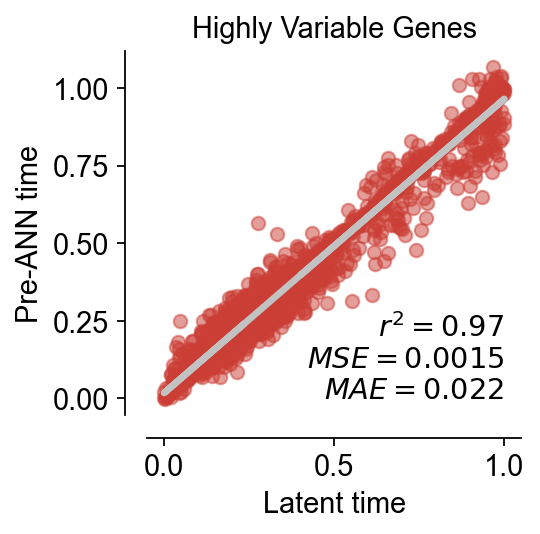

In [118]:
fig, ax = plt.subplots(figsize=(3,3))
fontsize=13
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
line = slope * y_test + intercept

# 计算置信区间的上界和下界
confidence_interval = 1.96 * std_err  # 95% 置信区间

upper_bound = line + confidence_interval
lower_bound = line - confidence_interval

ax.scatter(y_test,
            y_pred,
            color=ov.utils.red_color[2],
          alpha=0.5)

ax.plot(y_test, line, color='#c2c2c2', 
        label='Fit: y = {:.2f}x + {:.2f}'.format(slope, intercept),
    linewidth=3)
ax.fill_between(y_test, lower_bound, upper_bound, 
                color='grey', alpha=0.2, label='95% Confidence Interval')

#sns.regplot(x=y_test,y=y_pred,ax=ax,line_kws={'color':color},
#        color=color)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlabel('Latent time',fontsize=fontsize)
ax.set_ylabel('Pre-ANN time',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
legend_loc=[0.2,0.1,0]
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ax.text(1,legend_loc[0],'$r^2={:.2}$'.format(r2),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[1],'$MSE={:.2}$'.format(mse),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[2],'$MAE={:.2}$'.format(mae),fontsize=fontsize,horizontalalignment='right')

ax.set_title(f'Highly Variable Genes',
            fontsize=fontsize)

plt.savefig("figures/fig2/reg_hvgs.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/reg_hvgs.pdf",dpi=300,bbox_inches = 'tight')

## Non-HVGs-train

In [41]:
human_ret_gene=[]
with open('data/human_ret_gene_high_10276.txt','r') as f:
    for i in f.readlines():
        human_ret_gene.append(i.replace('\n',''))
human_ret_gene[:10],len(human_ret_gene)

(['KCNQ4',
  'AC012184.1',
  'AC107871.2',
  'AC232271.1',
  'AC108134.3',
  'AL160313.1',
  'ZBTB45',
  'AL671710.1',
  'AC131212.3',
  'AC245100.7'],
 10599)

In [43]:
human_ret=list(set(human_ret_gene) & set(adata.var_names))

In [44]:
adata2=adata[:,human_ret].copy()
adata2

AnnData object with n_obs × n_vars = 3478 × 8535
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'mean', 'dispersions', 'dispersions_norm', 'mean', 'std', 'mt', 'n_cells', 'percent_cells', 'robust', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'scrublet', 'sex_colors', 

In [45]:
adata2=adata2[:,adata2.var['highly_variable_features']==False]
adata2

View of AnnData object with n_obs × n_vars = 3478 × 7775
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'manual_annotation', 'latent_time'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'mean', 'dispersions', 'dispersions_norm', 'mean', 'std', 'mt', 'n_cells', 'percent_cells', 'robust', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'scrublet', 'sex_c

In [46]:
ev.utils.lsi(adata2, n_components=100, n_iter=15)

In [52]:
ltnn_model1=ANNmodel(adata2,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=100,batch_size=100,
                    cpu='cuda:0')

In [53]:
ltnn_model1.train(n_epochs=100)

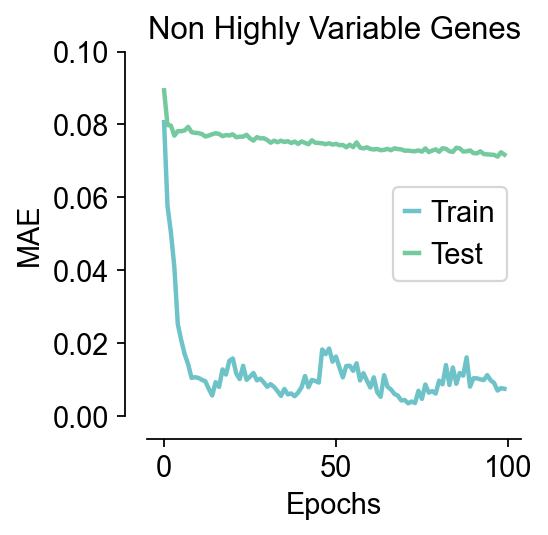

In [119]:
#定义图片大小
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))

epochs=100

ax.plot(range(epochs),ltnn_model1.train_maes,
         label='Train',color='#6ec3c8',lw=2)
ax.plot(range(epochs),ltnn_model1.val_maes,
         label='Test',color='#74c99f',lw=2)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlabel('Epochs',fontsize=fontsize)
ax.set_ylabel('MAE',fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(0,0.1)

#设置横纵坐标轴字体
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid(False)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.set_title(f'Non Highly Variable Genes',
            fontsize=fontsize+1)

plt.savefig("figures/fig2/mae_nhvgs.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/mae_nhvgs.pdf",dpi=300,bbox_inches = 'tight')

In [122]:
import seaborn as sns
X_val=adata2.obsm['X_lsi']
Y_val=adata2.obs['latent_time'].values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert x_test and y_test into PyTorch tensors and move to GPU
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.float32).to(device)


predicted=ltnn_model1.predicted(X_val)

y_test=Y_val.cpu().detach().numpy()
y_pred=predicted.cpu().detach().numpy().reshape(-1)

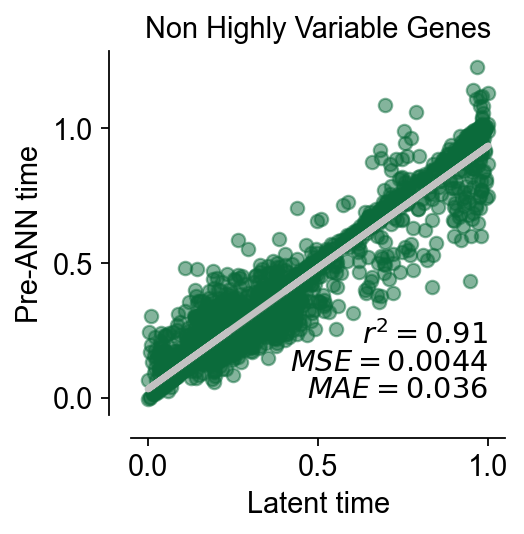

In [126]:
fig, ax = plt.subplots(figsize=(3,3))
fontsize=13
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
line = slope * y_test + intercept

# 计算置信区间的上界和下界
confidence_interval = 1.96 * std_err  # 95% 置信区间

upper_bound = line + confidence_interval
lower_bound = line - confidence_interval

ax.scatter(y_test,
            y_pred,
            color='#0b6b3b',
          alpha=0.5)

ax.plot(y_test, line, color='#c2c2c2', 
        label='Fit: y = {:.2f}x + {:.2f}'.format(slope, intercept),
    linewidth=3)
ax.fill_between(y_test, lower_bound, upper_bound, 
                color='grey', alpha=0.2, label='95% Confidence Interval')

#sns.regplot(x=y_test,y=y_pred,ax=ax,line_kws={'color':color},
#        color=color)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlabel('Latent time',fontsize=fontsize)
ax.set_ylabel('Pre-ANN time',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
legend_loc=[0.2,0.1,0]
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ax.text(1,legend_loc[0],'$r^2={:.2}$'.format(r2),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[1],'$MSE={:.2}$'.format(mse),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[2],'$MAE={:.2}$'.format(mae),fontsize=fontsize,horizontalalignment='right')

ax.set_title(f'Non Highly Variable Genes',
            fontsize=fontsize)

plt.savefig("figures/fig2/reg_nhvgs.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/reg_nhvgs.pdf",dpi=300,bbox_inches = 'tight')

## HVGs-LSI

In [174]:
scores={}
maes={}
losses={}

for i in [10,20,40,80,100]:
    #model=creat_radio_model(i)
    print('......lsi calculate',i)
    ev.utils.lsi(adata1, n_components=i, n_iter=15)
    model=ANNmodel(adata1,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=i,batch_size=30,
                    cpu='cuda:0')
    print('......model fit',i)
    model.train(n_epochs=200)
    maes[str(i)]=model.val_maes
    losses[str(i)]=model.val_losses
    print('......model finish',i)

......lsi calculate 10
......model fit 10
......model finish 10
......lsi calculate 20
......model fit 20
......model finish 20
......lsi calculate 40
......model fit 40
......model finish 40
......lsi calculate 80
......model fit 80
......model finish 80
......lsi calculate 100
......model fit 100
......model finish 100


In [175]:
import pickle
with open('data/hvgs_lsi_maes.pth', 'wb') as f:
    pickle.dump(maes, f)

with open('data/hvgs_lsi_losses.pth', 'wb') as f:
    pickle.dump(losses, f)

In [164]:
with open('data/hvgs_lsi_maes.pth', 'rb') as f:
    maes = pickle.load(f)

with open('data/hvgs_lsi_losses.pth', 'rb') as f:
    losses = pickle.load(f)

In [135]:
import pandas as pd
scores_pd=pd.DataFrame(columns=['loss','mean_absolute_error'])
for i in [10,20,40,80,100]:
    scores_pd.loc[str(i)]={'loss':np.min(losses[str(i)]),'mean_absolute_error':np.min(maes[str(i)])}
scores_pd.head()

,loss,mean_absolute_error
10,0.002876,0.034489
20,0.001993,0.031507
40,0.002830,0.037400
80,0.003256,0.040911
100,0.004087,0.045002


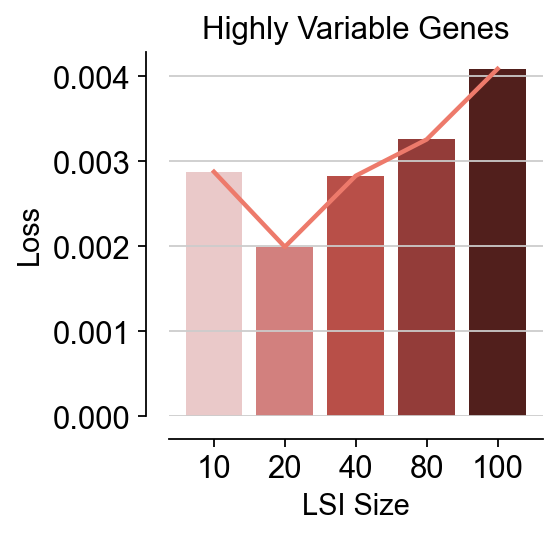

In [140]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd.index, y=scores_pd['loss'],ax=ax,palette=ov.utils.red_color)
sns.lineplot(x=scores_pd.index, y=scores_pd['loss'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('LSI Size',fontsize=13)
plt.ylabel('Loss',fontsize=13)
plt.title('Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/lsi_hvgs_loss.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/lsi_hvgs_loss.pdf",dpi=300,bbox_inches = 'tight')

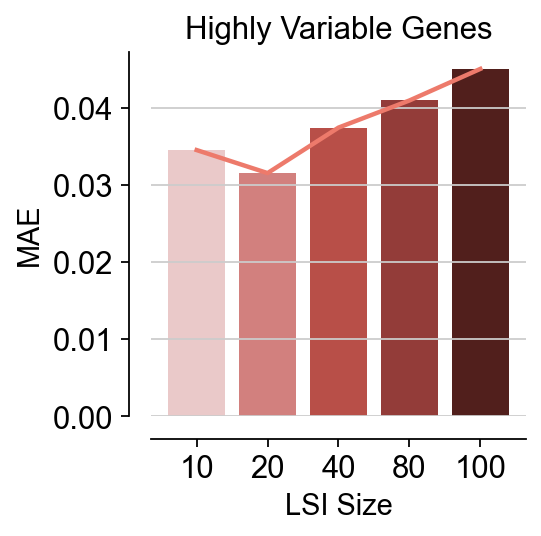

In [141]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd.index, y=scores_pd['mean_absolute_error'],ax=ax,palette=ov.utils.red_color)
sns.lineplot(x=scores_pd.index, y=scores_pd['mean_absolute_error'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('LSI Size',fontsize=13)
plt.ylabel('MAE',fontsize=13)
plt.title('Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/lsi_hvgs_mae.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/lsi_hvgs_mae.pdf",dpi=300,bbox_inches = 'tight')

## Non-HVGs-LSI

In [176]:
scores={}
maes={}
losses={}

for i in [10,20,40,80,100]:
    #model=creat_radio_model(i)
    print('......lsi calculate',i)
    ev.utils.lsi(adata2, n_components=i, n_iter=15)
    model=ANNmodel(adata2,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=i,batch_size=30,
                    cpu='cuda:0')
    print('......model fit',i)
    model.train(n_epochs=200)
    maes[str(i)]=model.val_maes
    losses[str(i)]=model.val_losses
    print('......model finish',i)

......lsi calculate 10
......model fit 10
......model finish 10
......lsi calculate 20
......model fit 20
......model finish 20
......lsi calculate 40
......model fit 40
......model finish 40
......lsi calculate 80
......model fit 80
......model finish 80
......lsi calculate 100
......model fit 100
......model finish 100


In [177]:
import pickle
with open('data/nhvgs_lsi_maes.pth', 'wb') as f:
    pickle.dump(maes, f)

with open('data/nhvgs_lsi_losses.pth', 'wb') as f:
    pickle.dump(losses, f)

In [164]:
with open('data/nhvgs_lsi_maes.pth', 'rb') as f:
    maes = pickle.load(f)

with open('data/nhvgs_lsi_losses.pth', 'rb') as f:
    losses = pickle.load(f)

In [145]:
import pandas as pd
scores_pd=pd.DataFrame(columns=['loss','mean_absolute_error'])
for i in [10,20,40,80,100]:
    scores_pd.loc[str(i)]={'loss':np.min(losses[str(i)]),'mean_absolute_error':np.min(maes[str(i)])}
scores_pd.head()

,loss,mean_absolute_error
10,0.006696,0.059127
20,0.005828,0.054951
40,0.007304,0.059625
80,0.008123,0.066259
100,0.008173,0.065413


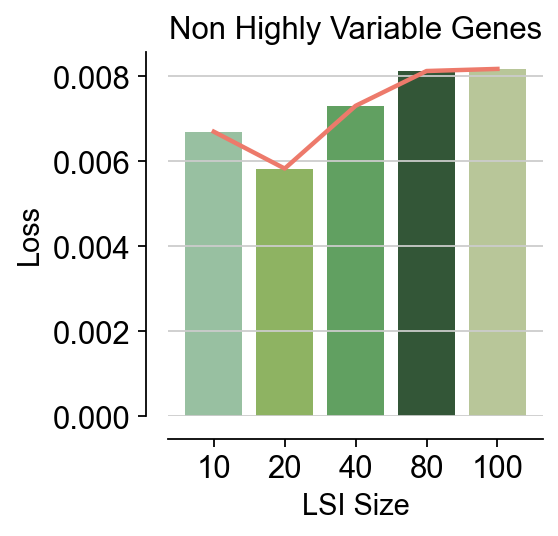

In [146]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd.index, y=scores_pd['loss'],ax=ax,palette=ov.utils.green_color)
sns.lineplot(x=scores_pd.index, y=scores_pd['loss'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('LSI Size',fontsize=13)
plt.ylabel('Loss',fontsize=13)
plt.title('Non Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/lsi_nhvgs_loss.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/lsi_nhvgs_loss.pdf",dpi=300,bbox_inches = 'tight')

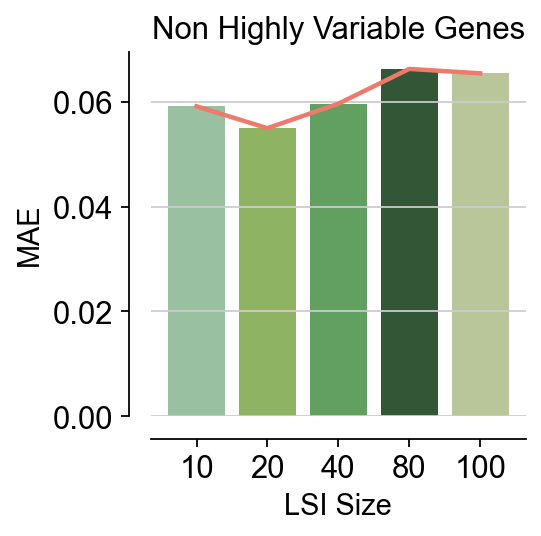

In [147]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd.index, y=scores_pd['mean_absolute_error'],ax=ax,palette=ov.utils.green_color)
sns.lineplot(x=scores_pd.index, y=scores_pd['mean_absolute_error'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('LSI Size',fontsize=13)
plt.ylabel('MAE',fontsize=13)
plt.title('Non Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/lsi_nhvgs_mae.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/lsi_nhvgs_mae.pdf",dpi=300,bbox_inches = 'tight')

## HVGs-batch

In [148]:
scores={}
maes={}
losses={}

for i in [10,20,30,40,50,60,70,80,90,100]:
    #model=creat_radio_model(i)
    print('......batch calculate',i)
    ev.utils.lsi(adata1, n_components=20, n_iter=15)
    model=ANNmodel(adata1,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=20,batch_size=i,
                    cpu='cuda:0')
    print('......model fit',i)
    model.train(n_epochs=200)
    maes[str(i)]=model.val_maes
    losses[str(i)]=model.val_losses
    print('......model finish',i)

......batch calculate 10
......model fit 10
......model finish 10
......batch calculate 20
......model fit 20
......model finish 20
......batch calculate 30
......model fit 30
......model finish 30
......batch calculate 40
......model fit 40
......model finish 40
......batch calculate 50
......model fit 50
......model finish 50
......batch calculate 60
......model fit 60
......model finish 60
......batch calculate 70
......model fit 70
......model finish 70
......batch calculate 80
......model fit 80
......model finish 80
......batch calculate 90
......model fit 90
......model finish 90
......batch calculate 100
......model fit 100
......model finish 100


In [163]:
import pickle
with open('data/hvgs_batch_maes.pth', 'wb') as f:
    pickle.dump(maes, f)

with open('data/hvgs_batch_losses.pth', 'wb') as f:
    pickle.dump(losses, f)

In [164]:
with open('data/hvgs_batch_maes.pth', 'rb') as f:
    maes = pickle.load(f)

with open('data/hvgs_batch_losses.pth', 'rb') as f:
    losses = pickle.load(f)

In [165]:
import pandas as pd
scores_pd_batch=pd.DataFrame(columns=['loss','mean_absolute_error'])
for i in [10,20,30,40,50,60,70,80,90,100]:
    scores_pd_batch.loc[str(i)]={'loss':np.min(losses[str(i)]),'mean_absolute_error':np.min(maes[str(i)])}
scores_pd_batch

,loss,mean_absolute_error
10,0.001731,0.028647
20,0.001668,0.028391
30,0.001944,0.027956
40,0.001882,0.028835
50,0.001933,0.029247
60,0.002055,0.029914
70,0.002090,0.029423
80,0.001798,0.028831
90,0.002150,0.030765
100,0.002472,0.031252


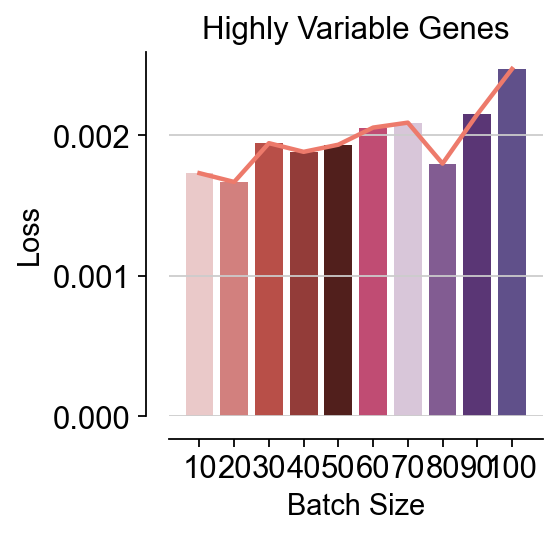

In [166]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd_batch.index, y=scores_pd_batch['loss'],ax=ax,palette=ov.utils.red_color)
sns.lineplot(x=scores_pd_batch.index, y=scores_pd_batch['loss'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('Batch Size',fontsize=13)
plt.ylabel('Loss',fontsize=13)
plt.title('Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/batch_hvgs_loss.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/batch_hvgs_loss.pdf",dpi=300,bbox_inches = 'tight')

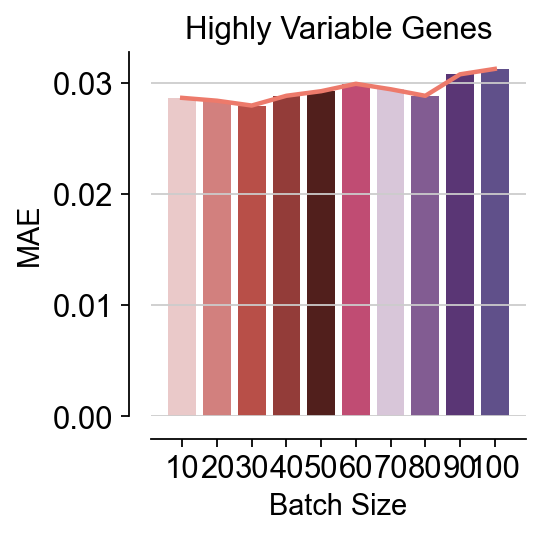

In [167]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd_batch.index, y=scores_pd_batch['mean_absolute_error'],ax=ax,palette=ov.utils.red_color)
sns.lineplot(x=scores_pd_batch.index, y=scores_pd_batch['mean_absolute_error'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('Batch Size',fontsize=13)
plt.ylabel('MAE',fontsize=13)
plt.title('Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/batch_hvgs_mae.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/batch_hvgs_mae.pdf",dpi=300,bbox_inches = 'tight')

## Non-HVGs-batch

In [168]:
scores={}
maes={}
losses={}

for i in [10,20,30,40,50,60,70,80,90,100]:
    #model=creat_radio_model(i)
    print('......batch calculate',i)
    ev.utils.lsi(adata2, n_components=20, n_iter=15)
    model=ANNmodel(adata2,basis='X_lsi',
                     pseudotime='latent_time',
                     input_dim=20,batch_size=i,
                    cpu='cuda:0')
    print('......model fit',i)
    model.train(n_epochs=200)
    maes[str(i)]=model.val_maes
    losses[str(i)]=model.val_losses
    print('......model finish',i)

......batch calculate 10
......model fit 10
......model finish 10
......batch calculate 20
......model fit 20
......model finish 20
......batch calculate 30
......model fit 30
......model finish 30
......batch calculate 40
......model fit 40
......model finish 40
......batch calculate 50
......model fit 50
......model finish 50
......batch calculate 60
......model fit 60
......model finish 60
......batch calculate 70
......model fit 70
......model finish 70
......batch calculate 80
......model fit 80
......model finish 80
......batch calculate 90
......model fit 90
......model finish 90
......batch calculate 100
......model fit 100
......model finish 100


In [169]:
import pickle
with open('data/nhvgs_batch_maes.pth', 'wb') as f:
    pickle.dump(maes, f)

with open('data/nhvgs_batch_losses.pth', 'wb') as f:
    pickle.dump(losses, f)

In [170]:
with open('data/nhvgs_batch_maes.pth', 'rb') as f:
    maes = pickle.load(f)

with open('data/nhvgs_batch_losses.pth', 'rb') as f:
    losses = pickle.load(f)

In [171]:
import pandas as pd
scores_pd_batch=pd.DataFrame(columns=['loss','mean_absolute_error'])
for i in [10,20,30,40,50,60,70,80,90,100]:
    scores_pd_batch.loc[str(i)]={'loss':np.min(losses[str(i)]),'mean_absolute_error':np.min(maes[str(i)])}
scores_pd_batch

,loss,mean_absolute_error
10,0.006407,0.055584
20,0.005940,0.055741
30,0.006776,0.057556
40,0.006121,0.055932
50,0.006278,0.058041
60,0.006629,0.058131
70,0.007121,0.059245
80,0.007432,0.061131
90,0.006848,0.057928
100,0.006874,0.058232


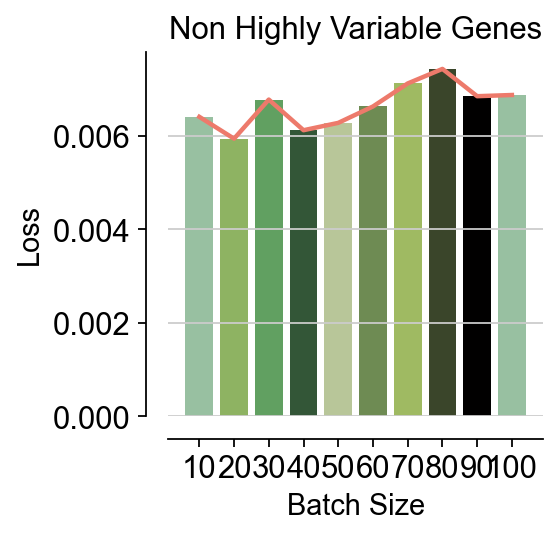

In [172]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd_batch.index, y=scores_pd_batch['loss'],ax=ax,palette=ov.utils.green_color)
sns.lineplot(x=scores_pd_batch.index, y=scores_pd_batch['loss'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('Batch Size',fontsize=13)
plt.ylabel('Loss',fontsize=13)
plt.title('Non Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/batch_nhvgs_loss.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/batch_nhvgs_loss.pdf",dpi=300,bbox_inches = 'tight')

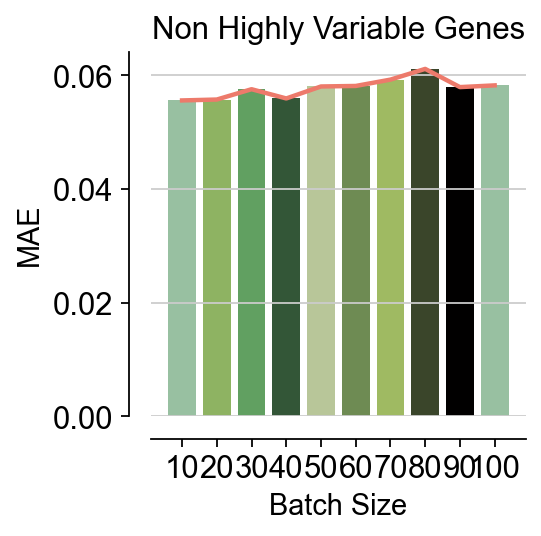

In [173]:
fig, ax = plt.subplots(figsize=(3,3))
sns.barplot(x=scores_pd_batch.index, y=scores_pd_batch['mean_absolute_error'],ax=ax,palette=ov.utils.green_color)
sns.lineplot(x=scores_pd_batch.index, y=scores_pd_batch['mean_absolute_error'],ax=ax,lw=2,color='#ed7a6b')
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.xlabel('Batch Size',fontsize=13)
plt.ylabel('MAE',fontsize=13)
plt.title('Non Highly Variable Genes',fontsize=14)

plt.savefig("figures/fig2/batch_nhvgs_mae.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/batch_nhvgs_mae.pdf",dpi=300,bbox_inches = 'tight')

## LTNN time

In [438]:
adata_time=sc.read('data/scvelo-pancreas.h5ad')
adata_time

AnnData object with n_obs × n_vars = 3696 × 1945
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'spearmans_score', 'velocity_score', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'clusters_sizes', 'day_colors', 'neighbors', 'paga', 'pca', 'rank_dynamical_genes', 'rank_velocity_genes', 'recover_dynami

In [439]:
adata_new=sc.read('data/Pancreas.h5ad')
adata_new.obs=adata_time.obs.loc[adata_new.obs.index.to_list()].copy()

In [442]:
adata_new.write_h5ad('data/Pancreas-velocyto.h5ad',compression='gzip')

In [338]:
adata_new=ov.pp.qc(adata_new,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250})
adata_new=ov.pp.preprocess(adata_new,mode='shiftlog|pearson',n_HVGs=3000,)
adata_new

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 3696
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 12261 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 56.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
    Scrublet finished (0:00:03)
Cells retained after scrublet: 3688, 8 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresho

AnnData object with n_obs × n_vars = 3688 × 15735
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'highly_variable_genes', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'scrublet', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

In [340]:
adata3=adata_new.copy()
import scanpy as sc
#sc.pp.highly_variable_genes(adata3, n_top_genes=3000, flavor="seurat_v3")
adata3=adata3[:,adata3.var['highly_variable_features']==True]
adata3

View of AnnData object with n_obs × n_vars = 3688 × 3000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'highly_variable_genes', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'scrublet', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

In [365]:
ev.utils.lsi(adata3, n_components=20, n_iter=15)

In [343]:
adata3

AnnData object with n_obs × n_vars = 3688 × 3000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'phase', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'highly_variable_genes', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'scrublet', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap', 'X_lsi'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

In [416]:
ltnn_obj=scLTNN(adata3,basis='X_lsi',input_dim=20,)

In [417]:
ltnn_obj.ANNmodel_init(pseudotime='latent_time',batch_size=20,)
ltnn_obj.ANNmodel_train(n_epochs=200)
ltnn_obj.ANNmodel_save('model/model_20.h5')

Pre-ANN model: 100%|██████████| 200/200 [00:43<00:00,  4.64it/s, val loss, val mae=0.00053, 0.00053]


In [418]:
ltnn_obj.ANNmodel_load('model/model_20.h5')
ltnn_obj.cal_paga()
ltnn_obj.cal_model_time()

......calculate paga
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
......predict model_time


In [419]:
ltnn_obj.cal_exp_gene_value()

In [420]:
ltnn_obj.cal_dpt_pseudotime(leiden_range_start=0.1)

......calculate dpt_pseudotime
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9991184  0.9940237  0.9874657  0.98432904 0.98151076
     0.9766722  0.97141707 0.96666044 0.95538634 0.95076346 0.94505423
     0.9397547  0.93572956 0.93157494]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
......leiden_start: ['3', '9', '0']
......leiden_middle ['4']
......leiden_end ['8']


--> added 'pos', the PAGA positions (adata.uns['paga'])


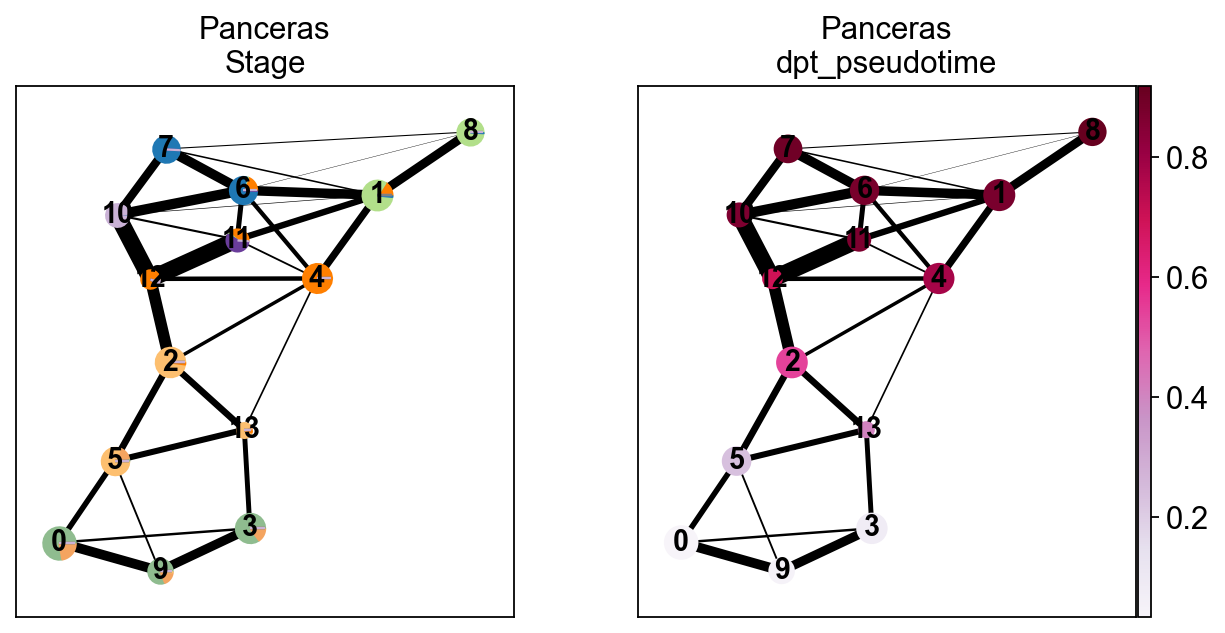

In [421]:
sc.pl.paga(ltnn_obj.adata, color=['clusters','dpt_pseudotime'],cmap='PuRd',
          title=['Panceras\nStage','Panceras\ndpt_pseudotime'],)
          #save='_fig3_pancreas.png')

In [ ]:
ltnn_obj.ANN(batch_size=30,n_epochs=200,verbose=0)

In [423]:
ltnn_obj.cal_distrubute()
ltnn_obj.cal_scLTNN_time()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 21.9905] [loc=0.528 scale=0.368]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 19.5744] [loc=0.000 scale=0.528]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 19.5744] [loc=-67108864.000 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.04 sec] [RSS: 13.8322] [loc=0.441 scale=0.392]


......Dweibull analysis


[distfit] >INFO> [t         ] [0.26 sec] [RSS: 21.99] [loc=0.528 scale=0.368]
[distfit] >INFO> [genextreme] [0.10 sec] [RSS: 17.93] [loc=0.496 scale=0.413]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 22.1083] [loc=-5.183 scale=0.024]
[distfit] >INFO> [lognorm   ] [0.16 sec] [RSS: 21.9831] [loc=-66.936 scale=67.465]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 17.4527] [loc=-0.116 scale=1.116]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 17.5213] [loc=0.000 scale=1.000]
[distfit] >INFO> [loggamma  ] [0.02 sec] [RSS: 15.2864] [loc=0.956 scale=0.019]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 12.8833] [loc=0.380 scale=0.273]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 13.4487] [loc=-0.049 scale=0.428]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 13.4487] [loc=-33554432.049 scale=33554432.000]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 10.0041] [loc=0.311 scale=0.2

......Norm analysis


[distfit] >INFO> [t         ] [0.26 sec] [RSS: 12.8832] [loc=0.380 scale=0.273]
[distfit] >INFO> [genextreme] [0.08 sec] [RSS: 13.1394] [loc=0.265 scale=0.242]
[distfit] >INFO> [gamma     ] [0.05 sec] [RSS: 12.0255] [loc=-0.049 scale=0.220]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 13.2875] [loc=-0.161 scale=0.466]
[distfit] >INFO> [beta      ] [0.05 sec] [RSS: 10.8671] [loc=-0.049 scale=1.048]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 12.7176] [loc=-0.049 scale=1.044]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 12.8594] [loc=-64.592 scale=9.234]
[distfit] >INFO> Compute confidence intervals [parametric]


......calculate scLTNN time


--> added 'pos', the PAGA positions (adata.uns['paga'])


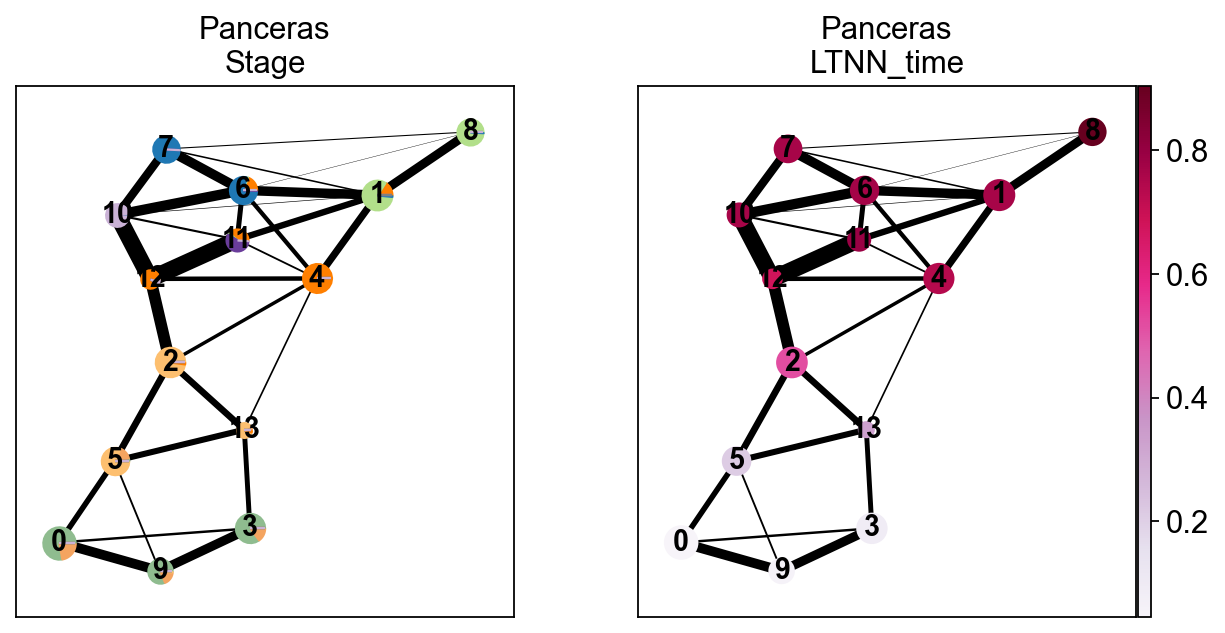

In [424]:
sc.pl.paga(ltnn_obj.adata, color=['clusters','LTNN_time'],cmap='PuRd',
          title=['Panceras\nStage','Panceras\nLTNN_time'],)
          #save='_fig3_pancreas.png')

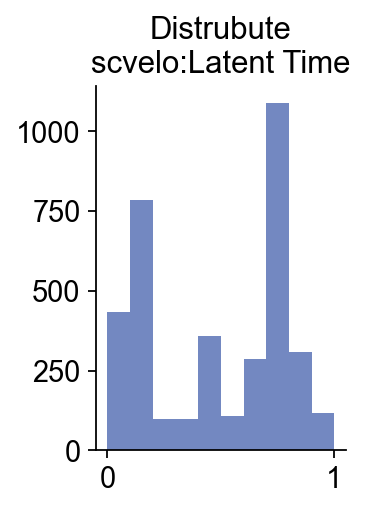

In [425]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2,3))
plt.hist(ltnn_obj.adata.obs['latent_time'],color='#7388c1')

#设置横纵坐标轴字体
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.grid(False)

plt.title('Distrubute\nscvelo:Latent Time',fontsize=14)
plt.savefig("figures/fig2/dis_latent_time.png",dpi=300,bbox_inches = 'tight')

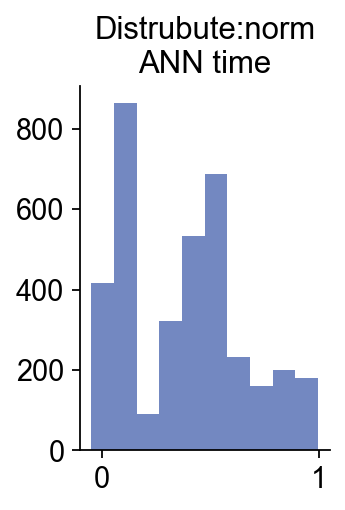

In [426]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2,3))

plt.hist(ltnn_obj.adata.obs['p_ANN_time'],color='#7388c1')
from scipy.stats import norm
import numpy as np

#设置横纵坐标轴字体
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.grid(False)
#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Distrubute:norm\nANN time',fontsize=14)
plt.savefig("figures/fig2/dis_ann_time.png",dpi=300,bbox_inches = 'tight')

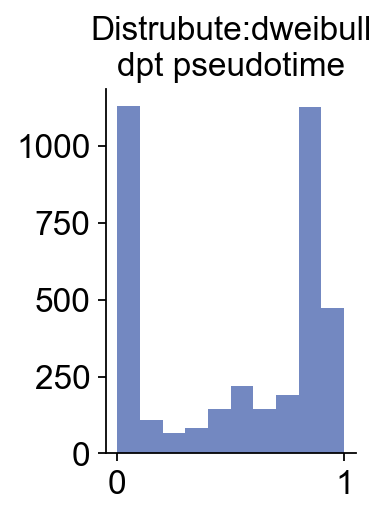

In [427]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2,3))

plt.hist(ltnn_obj.adata.obs['dpt_pseudotime'],color='#7388c1')
from scipy.stats import dweibull
import numpy as np

#设置横纵坐标轴字体,
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(False)
#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

plt.title('Distrubute:dweibull\ndpt pseudotime',fontsize=15)
plt.savefig("figures/fig2/dis_dpt_time.png",dpi=300,bbox_inches = 'tight')

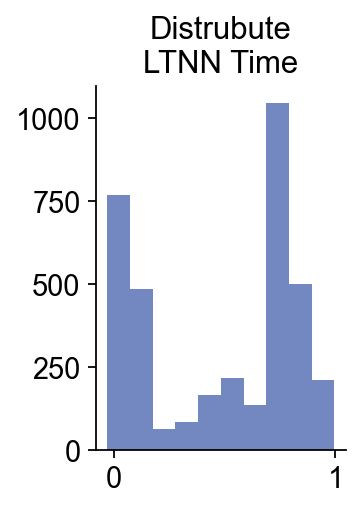

In [428]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2,3))
plt.hist(ltnn_obj.adata.obs['LTNN_time'],color='#7388c1')

#设置横纵坐标轴字体
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

#不显示右边跟上边
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.grid(False)


plt.title('Distrubute\nLTNN Time',fontsize=14)
plt.savefig("figures/fig2/dis_ltnn_time.png",dpi=300,bbox_inches = 'tight')

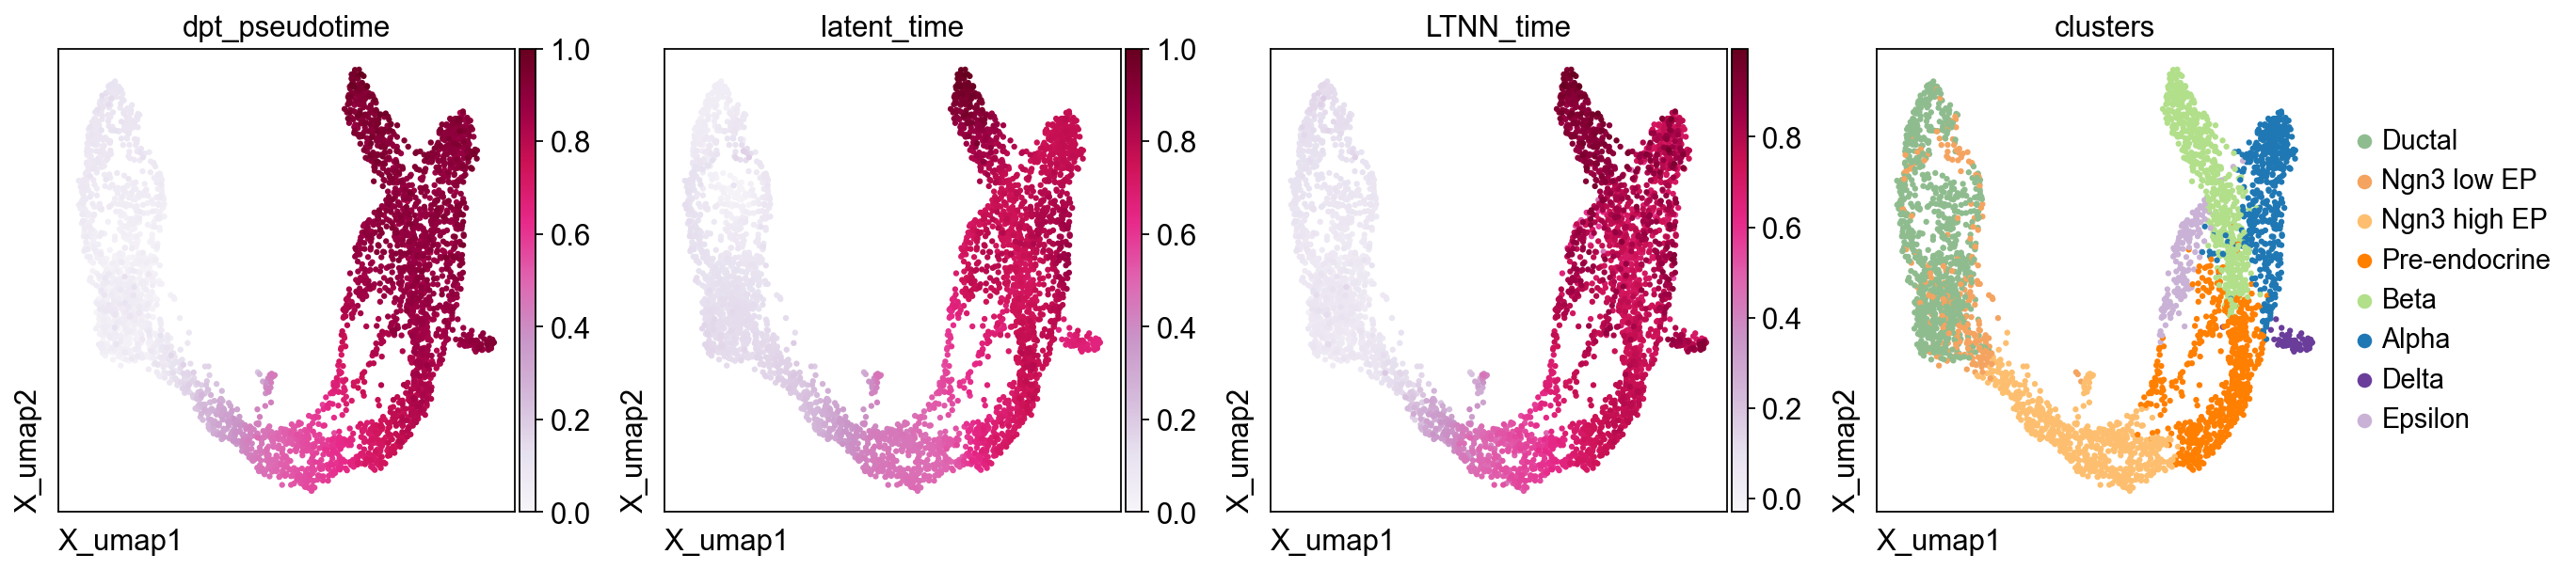

In [429]:
ov.utils.embedding(ltnn_obj.adata,basis='X_umap', color=['dpt_pseudotime','latent_time','LTNN_time','clusters'], 
               cmap='PuRd',legend_loc='right margin',)

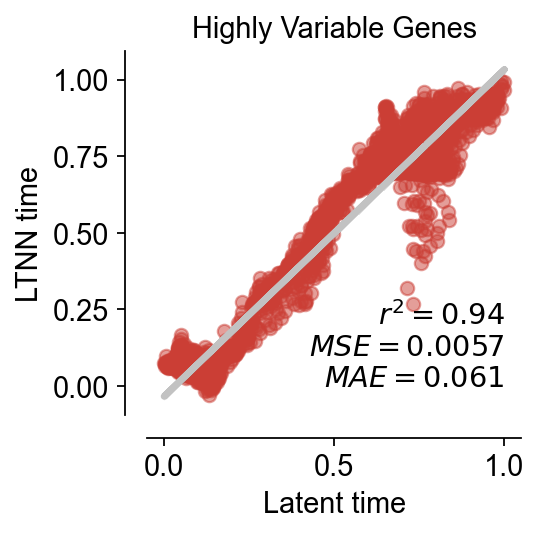

In [430]:
fig, ax = plt.subplots(figsize=(3,3))
fontsize=13
from scipy.stats import linregress
y_test=ltnn_obj.adata.obs['latent_time'].values
y_pred=ltnn_obj.adata.obs['LTNN_time'].values
slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)
line = slope * y_test + intercept

# 计算置信区间的上界和下界
confidence_interval = 1.96 * std_err  # 95% 置信区间

upper_bound = line + confidence_interval
lower_bound = line - confidence_interval

ax.scatter(y_test,
            y_pred,
            color=ov.utils.red_color[2],
          alpha=0.5)

ax.plot(y_test, line, color='#c2c2c2', 
        label='Fit: y = {:.2f}x + {:.2f}'.format(slope, intercept),
    linewidth=3)
ax.fill_between(y_test, lower_bound, upper_bound, 
                color='grey', alpha=0.2, label='95% Confidence Interval')

#sns.regplot(x=y_test,y=y_pred,ax=ax,line_kws={'color':color},
#        color=color)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlabel('Latent time',fontsize=fontsize)
ax.set_ylabel('LTNN time',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(False)
#设置spines可视化情况
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
legend_loc=[0.2,0.1,0]
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
ax.text(1,legend_loc[0],'$r^2={:.2}$'.format(r2),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[1],'$MSE={:.2}$'.format(mse),fontsize=fontsize,horizontalalignment='right')
ax.text(1,legend_loc[2],'$MAE={:.2}$'.format(mae),fontsize=fontsize,horizontalalignment='right')

ax.set_title(f'Highly Variable Genes',
            fontsize=fontsize)

plt.savefig("figures/fig2/reg_pancera.png",dpi=300,bbox_inches = 'tight')
plt.savefig("pdf/fig2/reg_pancera.pdf",dpi=300,bbox_inches = 'tight')

In [431]:
import scvelo as scv
ltnn_obj.adata.uns['paga_graph']=ltnn_obj.adata.obsp['connectivities']

In [436]:
scv.tl.paga(ltnn_obj.adata, groups='clusters',vkey='paga',use_time_prior='dpt_pseudotime')

running PAGA using priors: ['dpt_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


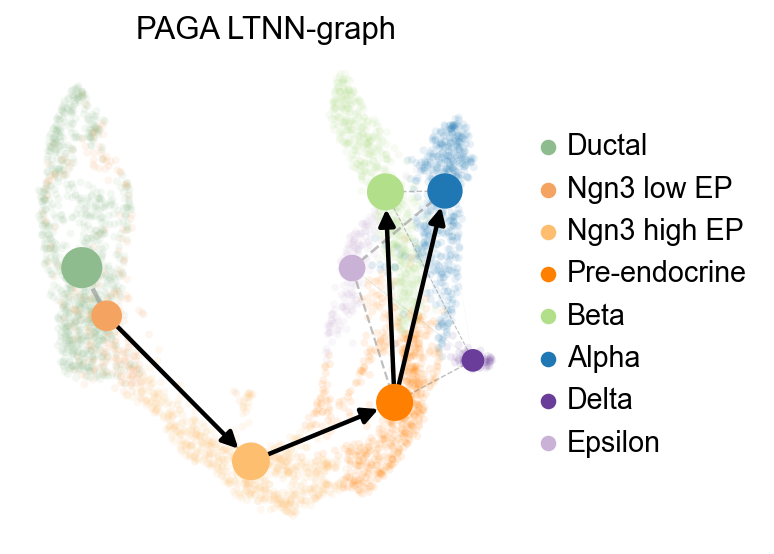

In [437]:
ax=scv.pl.paga(ltnn_obj.adata, basis='umap', size=50, alpha=.1,title='PAGA LTNN-graph',
            min_edge_width=2, node_size_scale=1.5,show=False)
#plt.savefig(current_path+'figures/CD8_paga.png',dpi=300,bbox_inches='tight')